# RAG with HuggingFace and LangChain

I wasn't able to find a simple example that worked right off the bat as things were either old/deprecated or required too many dependencies. I've tried to put together an example that works as of May 2024. Following this [blog](https://medium.com/@akriti.upadhyay/implementing-rag-with-langchain-and-hugging-face-28e3ea66c5f7)
#### Components needed

1. Documents for indexing and embedding

2. A Vector Store to have the embeddings and look-up

3. Retrieve the relevant information for the query from the documents

4. Choose LLM that will get the query + context to augment the response

Let's break down the components to uderstand how it works

#### What is RAG?
RAG or Retrieval Augmented Generation is a way to optimize the output from a LLM so that it uses facts from a set of provided documents to generate a response based on the base LLM. It is used to extend the abilities of the LLM that was trained for general purpose tasks and hone in on building enterprise solutions effectively. It achieves this without needing to fine-tune a model which is pretty time and cost intensive.

#### Why RAG?
It helps addressing some of the challenges of using LLM right off the bat. The goal of LLMs is to create systems that can be used to solve helpful problems, answering without knowledge of the problem it is trying to solve is too broad and not effective.

RAG can be used to generate up-to date information because we provide the documents and resources for it. It also reduces the hallucination in the models and reduces the occurenece of inaccurate reponses

#### How does it work?

1. Provide the external data source

2. Create embeddings of this and have it stored in a vector store for faster retrieval.
 
3. Given a query, retrieve relevant information form the documents (no LLM at this point)

4. Provide the model with a base LLM to augment the response by the retriever and passes it with context as a way to prompt engineer the LLM.

Got the following image from HuggingFace [blog](https://huggingface.co/blog/hrishioa/retrieval-augmented-generation-1-basics)


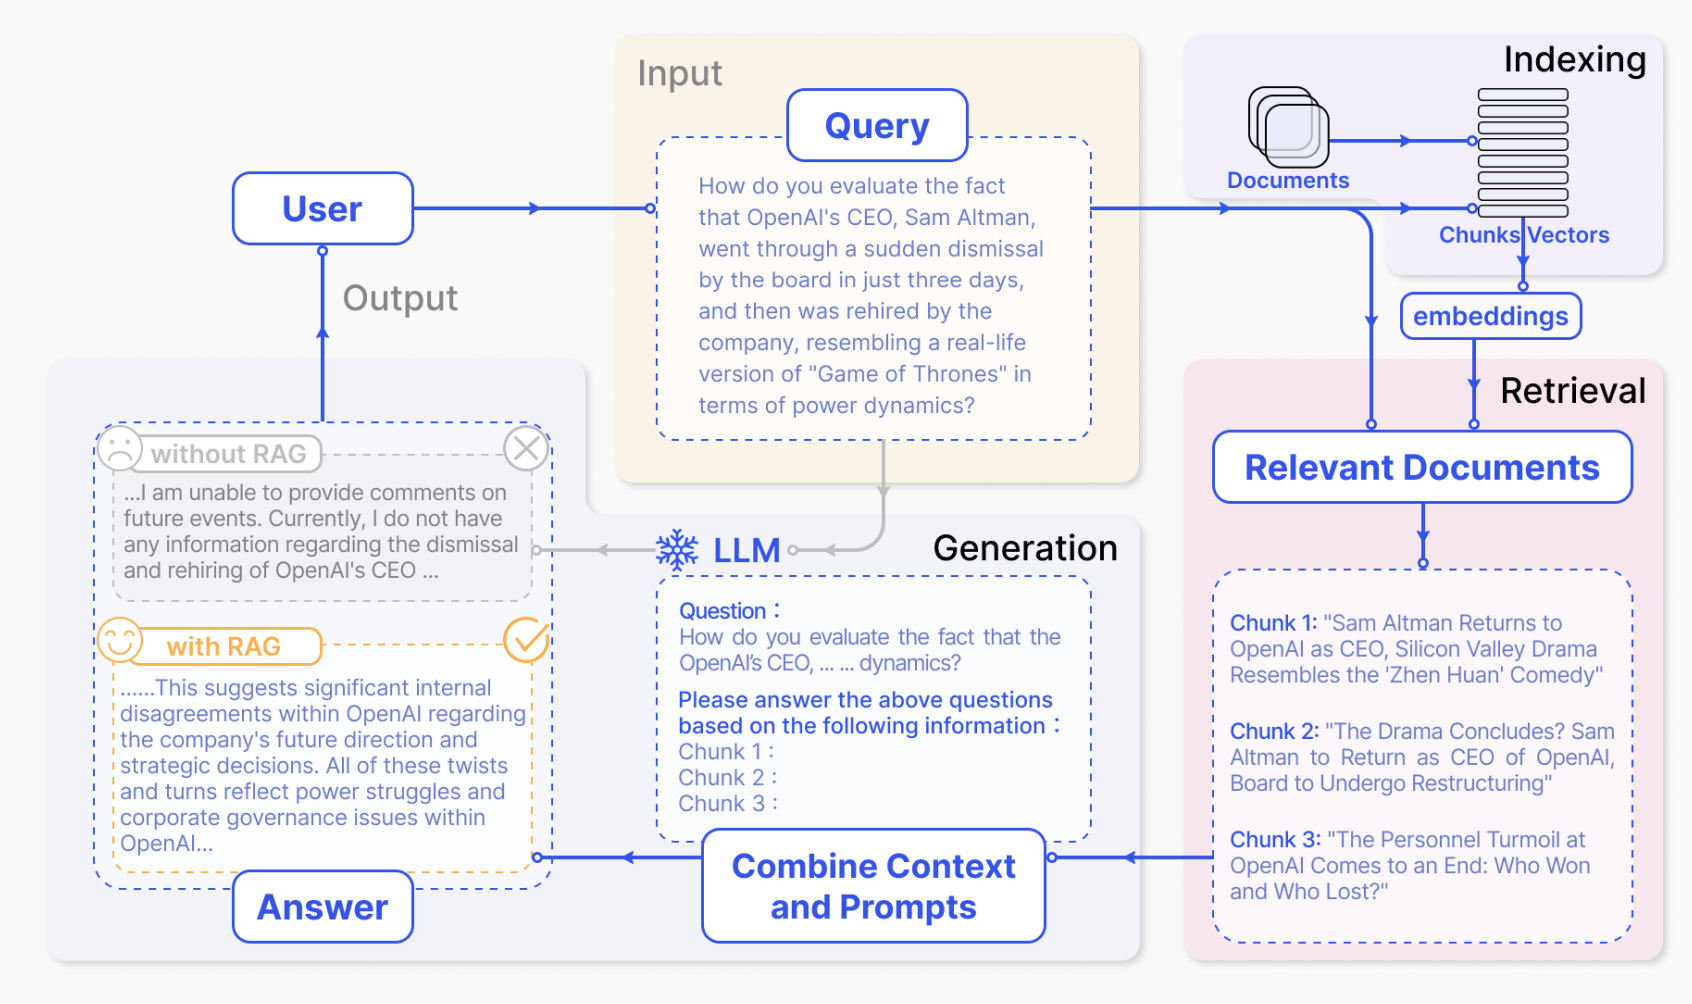


In [1]:
!pip install beautifulsoup4

In [2]:
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
from langchain import HuggingFacePipeline 
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
import bs4

from langchain.prompts import PromptTemplate

c:\Users\nansc\miniconda3\envs\pytorch_may2024\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Component 1: Documents Loader

LangChain is typically used to load documents that you may have. For the purpose of this example I will use open0-source huggingface dataset since I don't have to upload the PDF here.


In [3]:
loader = WebBaseLoader("https://docs.smith.langchain.com/user_guide")

data = loader.load()

In [4]:
# Need to split the text in the documents. Create an instance of the RecursiveCharacterTextSplitter class with specific parameters.
# It splits text into chunks of 1000 characters each with a 150-character overlap.
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)

# 'data' holds the text you want to split, split the text into documents using the text splitter.
docs = text_splitter.split_documents(data)

docs[1]

Document(page_content='Skip to main contentLangSmith API DocsSearchGo to AppQuick StartUser GuideTracingEvaluationProduction Monitoring & AutomationsPrompt HubProxyPricingSelf-HostingCookbookThis is outdated documentation for 🦜️🛠️ LangSmith, which is no longer actively maintained.For up-to-date documentation, see the latest version.User GuideOn this pageLangSmith User GuideLangSmith is a platform for LLM application development, monitoring, and testing. In this guide, we’ll highlight the breadth of workflows LangSmith supports and how they fit into each stage of the application development lifecycle. We hope this will inform users how to best utilize this powerful platform or give them something to consider if they’re just starting their journey.Prototyping\u200bPrototyping LLM applications often involves quick experimentation between prompts, model types, retrieval strategy and other parameters.', metadata={'source': 'https://docs.smith.langchain.com/user_guide', 'title': 'LangSmith U

### Component 2: Create Embeddings

Documents are ready in data

In [5]:
model_kwargs = {'device':'cpu'}

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-l6-v2",
                                   model_kwargs=model_kwargs)



c:\Users\nansc\miniconda3\envs\pytorch_may2024\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
db = FAISS.from_documents(docs, embeddings) # You can also use OpenAI embeddings or one of the many others provided by LangChain

Let's take a look at what this database now has using two tasks

1. Doing a similary search for the following query and returns k=3 documents

2. Using the database as a Retriever to get relevant documents for the query.

In [7]:
db.similarity_search("tasks", k=3)

[Document(page_content='traces in near real-time.Additionally, threads provide a seamless way to group traces from a single conversation, making it easier to track the performance of your application across multiple turns.Monitoring and A/B Testing\u200bLangSmith provides monitoring charts that allow you to track key metrics over time. You can expand to view metrics for a given period and drill down into a specific data point to get a trace table for that time period — this is especially handy for debugging production issues.LangSmith also allows for tag and metadata grouping, which allows users to mark different versions of their applications with different identifiers and view how they are performing side-by-side within each chart. This is helpful for A/B testing changes in prompt, model, or retrieval strategy.Automations\u200bAutomations are a powerful feature in LangSmith that allow you to perform actions on traces in near real-time. This can be used to automatically score traces, 

In [8]:
retriever = db.as_retriever(seacrh_kwargs={"k":3})
_docs = retriever.invoke("task decomposition")

_docs[0].page_content

'that allow you to perform actions on traces in near real-time. This can be used to automatically score traces, send them to annotation queues, or send them to datasets.To define an automation, simply provide a filter condition, a sampling rate, and an action to perform. Automations are particularly helpful for processing traces at production scale.Threads\u200bMany LLM applications are multi-turn, meaning that they involve a series of interactions between the user and the application. LangSmith provides a threads view that groups traces from a single conversation together, making it easier to track the performance of and annotate your application across multiple turns.Was this page helpful?PreviousQuick StartNextOverviewPrototypingBeta TestingProductionCommunityDiscordTwitterGitHubDocs CodeLangSmith SDKPythonJS/TSMoreHomepageBlogLangChain Python DocsLangChain JS/TS DocsCopyright © 2024 LangChain, Inc.'

### Component 4: LLM of your choice for Retrieval and Generation

This is the part where I struggled with the most. The original blog uses HuggingFacePipeline and a deprecated method to invoke.

In [9]:
model_id = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id)
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=512)
llm = HuggingFacePipeline(pipeline=pipe)

c:\Users\nansc\miniconda3\envs\pytorch_may2024\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
prompt = ChatPromptTemplate.from_template("""Answer the following question based only on the provided context:

<context>
{context}
</context>

Question: {input}""")

document_chain = create_stuff_documents_chain(llm, prompt)

In [12]:
from langchain_core.documents import Document

document_chain.invoke({
    "input": "how can langsmith help with testing?",
    "context": [Document(page_content="langsmith can let you visualize test results")]
})

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"Human: Answer the following question based only on the provided context:\n\n<context>\nlangsmith can let you visualize test results\n</context>\n\nQuestion: how can langsmith help with testing?\n\nSolution: langsmith can help with the following:\n\n<context>\n\n<context> langsmith can also set debug flag (in the documentation).\n\n</context>\n\nThen we can test it\n\nif (testFile =='test.txt') :\n\nbreak\n\nendif\n\nelse :\n\nassert $false == $true\n\n<context>\n\n<context> langsmith can create test directory structure\n\n</context>\n\n<context>\n\n<context> langsmith can create test path\n\n</context>\n\n</context>\n\n(end-of-test)\n\nNow we actually start it\n\nif (testFile =='test.txt') :\n\nbreak\n\nif (textFile % 10 =='test.txt!') :\n\n<context>\n\n<context> langsmith can create test root\n\n</context>\n\n</context>\n\n}\n\nelse :\n\n<context>\n\n<context> langsmith can create root test/testDirectory\n\n</context>\n\n</context>\n\n}\n\nNow of course we don't end up with a test fo

In [13]:
from langchain.chains import create_retrieval_chain

# retriever = db.as_retriever()
retrieval_chain = create_retrieval_chain(retriever, document_chain)

In [14]:
response = retrieval_chain.invoke({"input": "how can langsmith help with testing?"})
print(response["answer"])

# LangSmith offers several features that can help with testing:...

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Human: Answer the following question based only on the provided context:

<context>
We provide native rendering of chat messages, functions, and retrieve documents.Initial Test Set​While many developers still ship an initial version of their application based on “vibe checks”, we’ve seen an increasing number of engineering teams start to adopt a more test driven approach. LangSmith allows developers to create datasets, which are collections of inputs and reference outputs, and use these to run tests on their LLM applications.
These test cases can be uploaded in bulk, created on the fly, or exported from application traces. LangSmith also makes it easy to run custom evaluations (both LLM and heuristic based) to score test results.Comparison View​When prototyping different versions of your applications and making changes, it’s important to see whether or not you’ve regressed with respect to your initial test cases.
Oftentimes, changes in the prompt, retrieval strategy, or model choice ca


### Resources

This is a mix match between the following

[Implementing RAG with Langchain and Hugging Face](https://medium.com/@akriti.upadhyay/implementing-rag-with-langchain-and-hugging-face-28e3ea66c5f7) - works until Retrieval QA Chain

[Retrieval and Generation by LangChain](https://python.langchain.com/v0.1/docs/use_cases/question_answering/quickstart/) for the Retrieval portion that doesn't work from the above blog
    [RAG using LangChain and LlamaIndex](https://medium.com/@prasadmahamulkar/introduction-to-retrieval-augmented-generation-rag-using-langchain-and-lamaindex-bd0047628e2a)

Learnings

Encountered a lot of errors around expecting "SquadExample" or "dict" type when using blog #1, and "invoke" the final model.

The output of the retrieve needs to be formatted using format_docs before it can be passed to the llm.
